In [7]:
import pandas as pd
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from dtw import dtw
import light_curve as lc
from scipy.stats import poisson, norm
import time

In [2]:
import pickle

with open('data/nbd_array', 'rb') as f:
    nbd = pickle.load(f)

Comparing the GRB's :

`(2, [6,17,23])`

2 = GRB141205018  ; this is the center 

6 = GRB150312403

17 = GRB170130697

23 = GRB220415645

In [3]:
nbd[1][1]

[6, 17, 23]

In [4]:
# get the ra and dec values of grbs to compare
lcdf = pd.read_csv('data/gbmdatacleaned.csv', index_col=0) # light curve data frame

grb_index = nbd[1][1].copy()
grb_index.insert(0, nbd[1][0])
print(grb_index)

ra = [] #to hold ra values
dec = [] #to hold dec values
grbnames = []
for i in grb_index:
    ra.append(lcdf.iloc[i].ra_val)
    dec.append(lcdf.iloc[i].dec_val)
    grbnames.append(lcdf.name.iloc[i])

grbnumbers = [x[3:] for x in grbnames]

[2, 6, 17, 23]


In [5]:
# find the name of the brightest NaI detector
import estimate_source_angles_detectors as esad

for i in range(len(grb_index)):
    b = esad.angle_to_grb(ra[i],
                          dec[i],
                          '/Users/dimrisudhanshu/Downloads/current/glg_trigdat_all_bn' + grbnumbers[i] + '_v01.fit')
    print(b[0])

n8
n3
n3
n2


In [8]:
# open the fits file corresponding to the brightest NaI detectors
fitfile1 = fits.open('/Users/dimrisudhanshu/Downloads/current/glg_tte_n3_bn150312403_v01.fit')
fitfile2 = fits.open('/Users/dimrisudhanshu/Downloads/current/glg_tte_n3_bn170130697_v00.fit')
fitfile3 = fits.open('/Users/dimrisudhanshu/Downloads/current/glg_tte_n8_bn141205018_v00.fit')
fitfile4 = fits.open('/Users/dimrisudhanshu/Downloads/current/glg_tte_n2_bn'+grbnumbers[3]+'_v00.fit')

fitfiles = [fitfile2, fitfile3, fitfile4]

In [10]:
referenceLC = lc.getLightCurve(fitfile1)
ref_name = fitfile1[0].header['OBJECT']
distance_list = []
for fitfile in fitfiles:
    targetLC = lc.getLightCurve(fitfile)
    tar_name = fitfile[0].header['OBJECT']
    d = lc.getDTW(referenceLC, targetLC, ref_name, tar_name)
    distance_list.append(d)
    print(f'DTW : {d}')

DTW : 193570.0
DTW : 211693.0
DTW : 205974.0


In [11]:
def simulate(fitfile, size, num):
    '''
    function to simulate light curves with poisson distribution
    fitfile = GRB to simulate
    size = binsize of GRB
    num = number of simulated curves
    '''
    reference = lc.getLightCurve(fitfile, size)
    simcurves = []
    for i in range(num):
        curve = []
        for n in reference:
            curve.append(poisson.rvs(mu = n, size = 1)[0])
        simcurves.append(curve)
    
    return simcurves

In [13]:
start_time = time.time()
simulated_curves = simulate(fitfile1, 1, 1000)
dtw_list = []
for curve in simulated_curves:
    d = lc.getDTW(referenceLC, curve, '', '')
    dtw_list.append(d)
end_time = time.time()

print(f'Total time = {end_time - start_time}')

Total time = 22.959607124328613


5.542429712542277
10.264671239468086
8.77449305194457


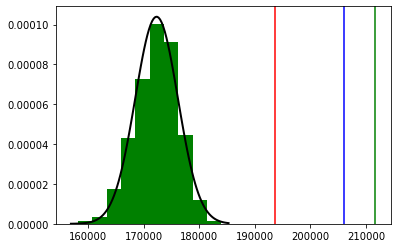

In [58]:
# mean and standard deviation of simulated dtw distance
mu, std = norm.fit(dtw_list)

# plot hist + normal distribution
plt.hist(dtw_list, density=True, color='g')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

# dtw distance of target curves
plt.axvline(distance_list[0], color='r')
plt.axvline(distance_list[1], color='g')
plt.axvline(distance_list[2], color='b')

# number of stdev away from mean
for d in distance_list:
    print((abs(mu - d))/std)